# Color Analysis

In [ ]:
from analyze import analyze_color_histogram
from scg_detection_tools.models import YOLO_NAS, YOLOv8
from scg_detection_tools.detect import Detector
from scg_detection_tools.utils.file_handling import read_yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import cv2

cfg = read_yaml("analyze_config.yaml")
model = YOLOv8(yolov8_ckpt_path=cfg["yolov8_model_path"])
#model = YOLO_NAS(model_arch=cfg["yolonas_arch"], 
#                checkpoint_path=cfg["yolonas_model_path"], 
#                classes=cfg["data_classes"])
det_params = cfg["detect_parameters"]
det_params["embed_slice_callback"] = None
det = Detector(detection_model=model, detection_params=det_params)


In [ ]:
from scg_detection_tools.utils.file_handling import get_all_files_from_paths

IMG_DIR = "/home/juliocesar/leaf-detection/imgs/light_group/images"
LBL_DIR = "/home/juliocesar/leaf-detection/imgs/light_group/labels"

#IMG_DIR = "/home/julio/Dev/SCG_IFSC/save/hemacias/images"

imgs = get_all_files_from_paths(IMG_DIR)

img_hists = analyze_color_histogram(model=model, 
                                    detector=det, 
                                    imgs=imgs, 
                                    raw=False, 
                                    on_detection_boxes=False,
                                    seg_annotations=LBL_DIR, 
                                    cspaces=["RGB", "HSV", "GRAY"], 
                                    show=True, save_plots=False)


In [ ]:
# Plot single channel images

import os

save = False
for img in imgs:
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
    
    rgb = cv2.imread(img)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(rgb.copy(), cv2.COLOR_RGB2HSV)
    LABELS = ["RGB", "HSV"]
    for ci, cp in enumerate([rgb, hsv]):
        for i in range(3):
            ch = cp.copy()
            for j in range(3):
                if i != j:
                    ch[:,:,j] = 0
            axs[ci][i].axis("off")
            axs[ci][i].imshow(ch)
            axs[ci][i].set_title(LABELS[ci][i])
    if save:
        fig.savefig(f"exp_analysis/singlechannel_{os.path.basename(img)}")
    plt.show()

In [ ]:
cspaceAnalysis = {"RGB": [], "HSV": [], "GRAY": [], "ALL": []}
nclass = {0: "light", 1: "medium", 2: "dark", 3: "dead"}
intensities = np.arange(256)
for img in img_hists:
    img_hist = img_hists[img]
    for cspace in ["RGB", "HSV", "GRAY"]:
        for mask_hist in img_hist[cspace]["masks"]:
            hist = mask_hist["hist"]
            mask_class = nclass[mask_hist["class"]]

            ch_stats = []
            for ch_hist in hist:
                ch_mean = np.sum(intensities * ch_hist) / np.sum(ch_hist)
                ch_std = np.sqrt(np.sum((intensities - ch_mean) ** 2 * ch_hist) / np.sum(ch_hist))
                ch_stats.append([ch_mean, ch_std])
            
            ch_stats = np.array(ch_stats).T.ravel().tolist()
            ch_stats.append(mask_class)
            cspaceAnalysis[cspace].append(ch_stats)


num_masks = len(cspaceAnalysis["RGB"])
all_mean = []
all_std = []
all_class = [data[-1] for data in cspaceAnalysis["RGB"]]

for maskidx in range(num_masks):
    all_mean.append([])
    all_std.append([])
    for cspace in ["RGB", "HSV", "GRAY"]:
        data = cspaceAnalysis[cspace][maskidx]
        if cspace == "GRAY":
            ch_mean = data[0]
            ch_std = data[1]
            all_mean[-1].append(ch_mean)
            all_std[-1].append(ch_std)
        else:
            ch_mean = data[:3]
            ch_std = data[3:-1]
            all_mean[-1].extend(ch_mean)
            all_std[-1].extend(ch_std)
for i in range(num_masks):
    cspaceAnalysis["ALL"].append([])
    
    cspaceAnalysis["ALL"][i].extend(all_mean[i])
    cspaceAnalysis["ALL"][i].extend(all_std[i])
    cspaceAnalysis["ALL"][i].append(all_class[i])

rgbdf = pd.DataFrame(cspaceAnalysis["RGB"], columns=[
    "R Mean", "G Mean", "B Mean", "R std", "G std", "B std", "Class"
])
hsvdf = pd.DataFrame(cspaceAnalysis["HSV"], columns=[
    "H Mean", "S Mean", "V Mean", "H std", "S std", "V std", "Class"
])
graydf = pd.DataFrame(cspaceAnalysis["GRAY"], columns=[
    "Gray mean", "Gray std", "Class"
])

alldf = pd.DataFrame(cspaceAnalysis["ALL"], columns=[
    "R Mean", "G Mean", "B Mean", "H Mean", "S Mean", "V Mean", "Gray mean", "R std", "G std", "B std", "H std", "S std", "V std", "Gray std", "Class"
])

class_c_map = {
    "light": "blue", 
    "medium": "green", 
    "dark": "red", 
    "dead": "black"
}

class_color = lambda df: df["Class"].map(class_c_map)

scatter_matrix(rgbdf.iloc[:,:-1], figsize=(12,12), diagonal="kde", color=class_color(rgbdf))
scatter_matrix(hsvdf.iloc[:,:-1], figsize=(12,12), diagonal="kde", color=class_color(hsvdf))
scatter_matrix(graydf.iloc[:,:-1], figsize=(12,12), diagonal="kde", color=class_color(graydf))
scatter_matrix(alldf.iloc[:,:-1], figsize=(20,20), diagonal="kde", color=class_color(alldf))

print(rgbdf.corr(numeric_only=True))
print(hsvdf.corr(numeric_only=True))
print(graydf.corr(numeric_only=True))

# Clustering and Classification

In [4]:
"""
KMeans:

Use k-means to find clusters based on leaf masks extracted with yolo and sam2
- (for now) use the features from above (RGB, HSV, Gray means and std), pass them to PSA
- to get it to 2 and 3 dimensions (compare them) then use them to train KMeans
- and also plot inertia x n_clusters to check for optimal values
"""

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# alldf is a dataset of 14 features (RGB,HSV,Gray)(Mean,STD) not including class
# it will only be used to color markers in plot
#print(alldf.head())
#print(alldf.iloc[:,:-1].values)
X = alldf.iloc[:,:-1].values

# Use PCA to reduce to 2d
reduced = PCA(n_components=2).fit_transform(X)

# Feature scaling to normalize values and have a stdv of 1 and mean of 0
# so first scale then apply PCA
scaler = StandardScaler().set_output(transform="pandas")
scaled_X = scaler.fit_transform(X)
scaled_PCA = PCA(n_components=2).fit_transform(scaled_X)

In [ ]:
# Analyze inertia to choose best numbmer for clusters
inertia = []
MAX_CLUSTERS = 15
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8), layout="tight")
for i, (name, data) in enumerate([("PCA reduced",reduced), ("Scale + PCA reduced",scaled_PCA)]):
    inertia = []
    for n in range(1, MAX_CLUSTERS):
        kmeans = KMeans(n_clusters=n, init="k-means++", n_init=10, max_iter=300,
                        tol=0.0001, random_state=0, algorithm="lloyd")
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    axs[i].plot(np.arange(1, MAX_CLUSTERS), inertia, marker='o')
    axs[i].set(xlabel="# Clusters", ylabel="Inertia", title=name)
    del inertia
plt.show()

In [ ]:
def kmeans_test(n_clusters, data, name):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", max_iter=300,
                   tol=0.001, random_state=0, algorithm="lloyd")

    kmeans.fit(data)

    ## visualization
    step = 0.02
    x_min, x_max = data[:,0].min() - 1, data[:,0].max() + 1
    y_min, y_max = data[:,1].min() - 1, data[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired, aspect="auto", origin="lower")

    for c in class_c_map:
        c_data = data[alldf["Class"] == c,:]
        ax.scatter(c_data[:,0], c_data[:,1], color=class_c_map[c], alpha=0.8)
    
    #ax.plot(reduced[:,0], reduced[:,1], )
    centroids = kmeans.cluster_centers_
    ax.scatter(centroids[:,0], centroids[:,1], marker="x", s=169, color="w", zorder=10, linewidth=3)
    ax.set(title=f"K-Means clustering on leaves masks using {name}",
           xlim=(x_min, x_max),
           ylim=(y_min, y_max))
    
    plt.show()

In [ ]:
kmeans_test(n_clusters=4, data=reduced, name="PCA reduced")

In [ ]:
kmeans_test(n_clusters=4, data=scaled_PCA, name="Scale + PCA reduced")

In [ ]:
# testing with sklearn pipeline
from sklearn.pipeline import Pipeline

N_CLUSTERS = 4
scaler = StandardScaler().set_output(transform="pandas")
pca = PCA(n_components=2)
pipe = Pipeline(
    steps=[("scaler", scaler), ("pca", pca)]
)
transformed = pipe.fit_transform(X)
kmeans_test(n_clusters=N_CLUSTERS, data=transformed, name="Pipeline: Scaler to PCA")

In [9]:
"""
K Nearest Neighbors:
- To decide on the value of K, test for a range
- Use a pipeline
"""

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

X = alldf.iloc[:,:-1].values
y = alldf.iloc[:,-1].values

encoder = LabelEncoder()
encoded = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, encoded, stratify=encoded, random_state=0)

In [ ]:
clf = Pipeline([
    ("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5)),
])

clf.fit(X_train, y_train)

In [ ]:
print(f"len X_test: {len(X_test)}")
predicted = clf.predict(X_test)

print(f"predicted,real:\n{[(p, r) for p,r in zip(encoder.inverse_transform(predicted), encoder.inverse_transform(y_test))]}")

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test), target_names=encoder.classes_))

In [ ]:
n_neighbors = np.arange(1, 15+1)
weights = ("uniform", "distance")

for n in n_neighbors:
    for weight in weights:
        clf = Pipeline(steps=[
          ("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=n, weights=weight)),
        ])
        clf.fit(X_train, y_train)

        print("_"*82)

        print(f"Classification report for k={n}, weights={weight!r}")
        print(classification_report(y_test, clf.predict(X_test), target_names=encoder.classes_))

        print("_"*82)


# Leaf color identification pipeline (light, medium, dark, dead)

### Using KNN trained above

In [ ]:
# get detection box
# segment leaf to exclude background (maybe not even needed)
# pass class + pixels to data

# -> specify size to standardize input (like 50x50, 80x80)
# -> ...

In [1]:
from scg_detection_tools.models import YOLO_NAS, YOLOv8
from scg_detection_tools.detect import Detector
from scg_detection_tools.utils.file_handling import read_yaml
import scg_detection_tools.utils.image_tools as imtools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import cv2

cfg = read_yaml("analyze_config.yaml")
model = YOLO_NAS(model_arch=cfg["yolonas_arch"], 
                checkpoint_path=cfg["yolonas_model_path"], 
                classes=cfg["data_classes"])
det_params = cfg["detect_parameters"]
det_params["embed_slice_callback"] = None
det = Detector(detection_model=model, detection_params=det_params)


[2024-09-07 19:27:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/juliocesar/leaf-detection/checkpoints/yolonas/large/train2/ckpt_best.pth EMA checkpoint.


In [2]:
import scg_detection_tools.utils.image_tools as imtools
import scg_detection_tools.utils.cvt as cvt
from scg_detection_tools.utils.file_handling import get_all_files_from_paths
from scg_detection_tools.dataset import read_dataset_annotation
from analyze import parse_seg_annotations
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

IMG_DIR = "/home/juliocesar/leaf-detection/imgs/light_group/images"
LBL_DIR = "/home/juliocesar/leaf-detection/imgs/light_group/labels"

imgs = get_all_files_from_paths(IMG_DIR, skip_ext=[".txt", ".json", ".yaml"])
ann_files, img_ann_idx = parse_seg_annotations(imgs, LBL_DIR)

# Keep track of every object as (nclass, obj_crop)
obj_data = []

# CHOOSING 32x32 because of calculated average
STANDARD_SIZE = (32, 32)

# !!!!!! taken from data.yaml
class_map = {0: "dark", 1: "dead", 2: "light", 3: "medium"}

for img in imgs:
    ann_file = ann_files[img_ann_idx[img]]
    annotations = read_dataset_annotation(ann_file, separate_class=False)

    # check if contours are boxes or segments
    orig = cv2.imread(img)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    imgsz = orig.shape[:2]

    for ann in annotations:
        nclass = ann[0]
        contour = ann[1:]
        if len(contour) == 4:
            mask = cvt.boxes_to_masks([contour], imgsz=imgsz, normalized=True)[0]
        else:
            mask = cvt.contours_to_masks([contour], imgsz=imgsz, normalized=True)[0]
        
        # get only segmented object from image
        masked = deepcopy(orig)
        masked[mask[:,:] < 255] = 0

        # crop a box around it
        points = np.array(contour).reshape(len(contour) // 2, 2)
        box = cvt.segment_to_box(points, normalized=True, imgsz=imgsz)
        obj_crop = imtools.crop_box_image(masked, box)

        # resize to 32x32 and add to our data
        obj_crop = cv2.resize(obj_crop, STANDARD_SIZE, cv2.INTER_CUBIC)
        obj_data.append((nclass, obj_crop))


# Get average object size
# avg_h = 0
# avg_w = 0
# for obj in obj_data:
#     h, w = obj[1].shape[:2]
#     avg_h += h
#     avg_w += w
# print(f"Average: W={avg_w / len(obj_data)}, H={avg_h / len(obj_data)}")

In [3]:
# Take 'obj_data' and split it to have a 'X' vector including the object crops and 'y' being the classes
y = []
X = []
for (nclass, obj_crop) in obj_data:
    y.append(nclass)

    # For the X vector, we want to include the object as a 32x32x3=3072 length vector
    # but we're also including the HSV and Gray cropped object
    # so the final array to append to our vector must be of size 32x32x(3 + 3 + 1) = 7168
    hsv = cv2.cvtColor(obj_crop, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(obj_crop, cv2.COLOR_RGB2GRAY)

    flat_rgb = obj_crop.flatten() # shape 32x32x3 = 3072
    flat_hsv = hsv.flatten() # shape 32x32x3 = 3072
    flat_gray = gray.flatten() # shape 32x32x1 = 1024

    final = np.concatenate((flat_rgb, flat_hsv, flat_gray))
    X.append(final)

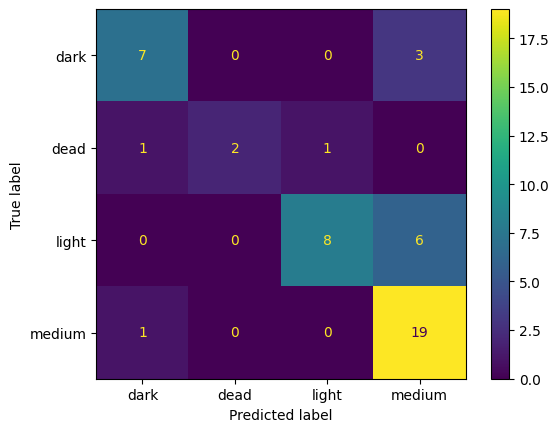

set()
{0: 'dark', 1: 'dead', 2: 'light', 3: 'medium'}
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       1.00      0.50      0.67         4
           2       0.89      0.57      0.70        14
           3       0.68      0.95      0.79        20

    accuracy                           0.75        48
   macro avg       0.84      0.68      0.72        48
weighted avg       0.79      0.75      0.74        48



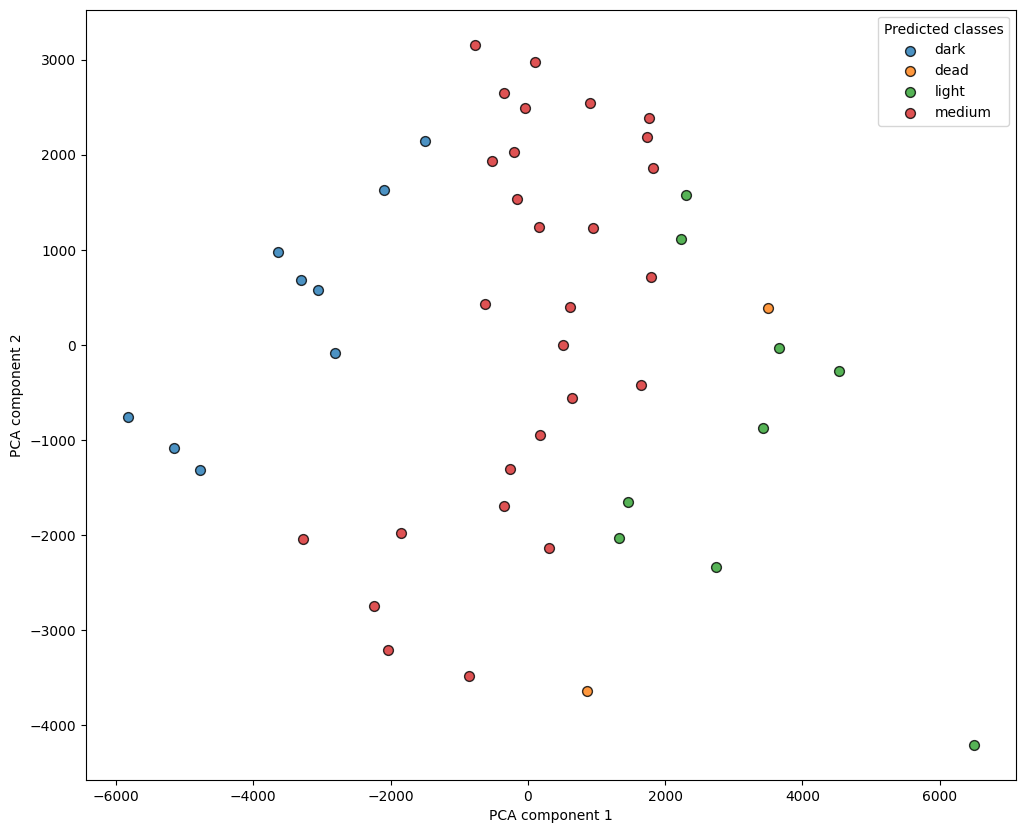

In [5]:
# Now we train KNN with our data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay



X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

N_NEIGHBORS = 8
clf = Pipeline(
    steps=[ 
        ("scaler", StandardScaler()), 
        ("knn", KNeighborsClassifier(n_neighbors=N_NEIGHBORS, weights="distance")),
    ]
)
clf.fit(X_train, y_train)

# Test predictions
predictions = clf.predict(X_test)
print(set(y_test) - set(predictions))
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_map[c] for c in class_map])
print(class_map)
print(classification_report(y_test, predictions, labels=clf.classes_))
disp.plot()
plt.show()

# Visualization KNN
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

fig, ax = plt.subplots(figsize=(12,10))
for cls in np.unique(predictions):
    ax.scatter(X_test_pca[predictions == cls, 0], 
               X_test_pca[predictions == cls, 1], 
               label=f"{class_map[cls]}", 
               s=50, 
               edgecolor='k', 
               alpha=0.8)
ax.set(xlabel="PCA component 1", ylabel="PCA component 2")
ax.legend(title="Predicted classes")

plt.show()


In [ ]:


# Using KNN trained above to predict on untrained image
img = "/home/juliocesar/leaf-detection/scg-leaf-count/imgs/test/5_640x640_sparse.png"

# -> get image detections
# -> crop and segment
# -> predict color class
# -> display image with color labels

detections = det(img)[0]
ann_img = imtools.box_annotated_image(img, detections, box_thickness=2)
imtools.plot_image(ann_img)


In [ ]:
from scg_detection_tools.segment import SAM2Segment

seg = SAM2Segment(sam2_ckpt_path=cfg["sam2_ckpt_path"],
                  sam2_cfg=cfg["sam2_cfg"])

masks = seg._segment_detection(img, detections)

In [9]:
import scg_detection_tools.utils.cvt as cvt

boxes = detections.xyxy.astype(np.int32)
orig_img = cv2.imread(img)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

obj_data = []
OBJ_STD_SIZE = (32,32)

# Apply mask to segment our image and crop a box around the segmented object
for box, mask in zip(boxes, masks):
    w, h = mask.shape[1:]
    mask = mask.astype(np.uint8).reshape(h, w,)
    mask = np.where(mask == 1, 255, 0)

    masked = deepcopy(orig_img)
    masked[mask[:,:] < 255] = 0

    obj_crop = imtools.crop_box_image(masked, box)
    obj_crop = cv2.resize(obj_crop, OBJ_STD_SIZE, cv2.INTER_CUBIC)

    obj_data.append([box, mask, obj_crop])

In [ ]:
# Process our object crops to prepare them as input for KNN
# -> calculate hsv and gray, then make predictions and append class to our obj data
for i, (box, mask, obj) in enumerate(obj_data):
    hsv = cv2.cvtColor(obj, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(obj, cv2.COLOR_RGB2GRAY)
    rgb = obj

    attributes = np.concatenate((rgb.flatten(), hsv.flatten(), gray.flatten()))
    nclass = clf.predict([attributes])[0]
    obj_data[i].append(nclass)

print(len(obj_data[0]))

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

class_color = {
    "light": "deepskyblue",
    "medium": "lime",
    "dark": "red",
    "dead": "black",
}

color_patches = [
    mpatches.Patch(color=class_color[c], label=c) for c in class_color 
]

fig, axs = plt.subplots(ncols=2, figsize=(15,10))
axs[0].imshow(orig_img)
axs[1].imshow(orig_img)

for box, mask, obj_crop, nc in obj_data:

    class_name = class_map[nc]
    h, w = mask.shape
    _mask = np.where(mask == 255, 1, 0).astype(np.uint8).reshape(h, w, 1)
    
    color = []
    color.extend(mcolors.to_rgb(class_color[class_name]))
    color.append(0.6)
    mask_img = _mask * np.array(color).reshape(1,1,-1)
    axs[1].imshow(mask_img)

axs[1].legend(handles=color_patches)

plt.show()


# Pixel density

In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
from analyze import analyze_pixel_density
from scg_detection_tools.utils.file_handling import get_all_files_from_paths
from pathlib import Path

IMG_DIR = "/home/juliocesar/leaf-detection/scg-leaf-count/imgs/analysis"
#LBL_DIR = "/home/juliocesar/leaf-detection/save/first_analysis_detections/out_cache/"

imgs = get_all_files_from_paths(IMG_DIR)

def sort_stem(item):
    s = Path(item).stem
    try:
        val = int(s)
        return val
    except:
        return s

imgs = sorted(imgs, key=sort_stem)
print(imgs)

densities = analyze_pixel_density(model=model, 
                                  detector=det, 
                                  imgs=imgs, 
                                  sam2_ckpt_path=cfg["sam2_ckpt_path"],
                                  sam2_cfg=cfg["sam2_cfg"],
                                  boxes=False,
                                  segments=True,
                                  slice_detection=True,
                                  on_slice=True,
                                  seg_annotations=None,
                                  cached_detections=None,
                                  show=True,
                                  save=False)
print(densities)